In [2]:
# Import packages
import ee
import geemap
import os
import time
import glob
import time
from osgeo import gdal, gdalconst
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as rxr
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from scipy.stats import linregress

c:\Users\Francesco\anaconda3\envs\env\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


DEM opened successfully
DEM size: 3601 x 3601
(-80.00013888888888, 0.0002777777777777778, 0.0, -0.9998611111111111, 0.0, -0.0002777777777777778)
DEM NoData value: -32767.0
DEM min value: -57
DEM max value: 4143


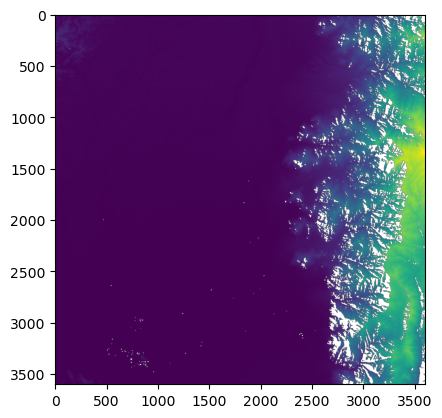

In [3]:
## DEM READING AND AOI CREATION
 
# Read a SRTM DEM on Guaranda, Bolivar Province (Ecuador)
dem_path = r"C:\Users\Francesco\Python\earthlab\data\Ecuador\DEM\s02_w080_1arc_v3.tif"
dem_img = gdal.Open(dem_path)

if dem_img is None:
    print("The DEM hasn't been read")
else:
    print("DEM opened successfully")
    print('DEM size:', dem_img.RasterXSize, 'x', dem_img.RasterYSize)

# Get the geotransform
dem_gt = dem_img.GetGeoTransform()
print(dem_gt)

# Get the band
dem_band = dem_img.GetRasterBand(1)

# Transform the raster in an array (numpy)
dem_cols = dem_img.RasterXSize
dem_rows = dem_img.RasterYSize
dem_np = dem_band.ReadAsArray(0, 0, dem_cols, dem_rows)

# Mask NoData
dem_nodata_value = dem_band.GetNoDataValue()
print('DEM NoData value:', dem_nodata_value)
dem_np = np.ma.masked_equal(dem_np, dem_nodata_value)

# Get min and max values in the array
print('DEM min value:', np.min(dem_np))
print('DEM max value:', np.max(dem_np))

# Show the DEM
plt.imshow(dem_np, vmin=0, vmax=4143)
plt.show()

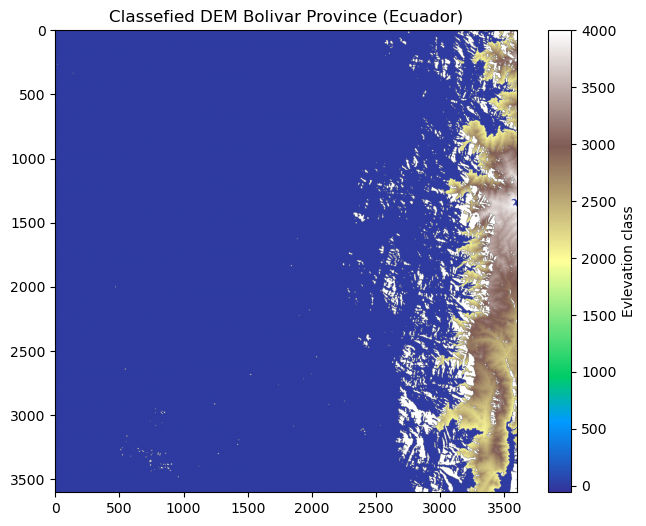

In [4]:
# Show the DEM classes <1000, 1000-2000, 3000-4000, >4000
dem_np_cl = dem_np.copy()

dem_np_cl[(dem_np_cl>0) & (dem_np_cl<=1000)] = 1
dem_np_cl[(dem_np_cl>1000) & (dem_np_cl<=2000)] = 2
dem_np_cl[(dem_np_cl>2000) & (dem_np_cl<=2000)] = 3
dem_np_cl[(dem_np_cl>4000)] = 4

plt.figure(figsize=(8, 6))
plt.imshow(dem_np_cl, cmap='terrain')
plt.colorbar(label='Evlevation class')
plt.title('Classefied DEM Bolivar Province (Ecuador)')
plt.show()

In [5]:
# Calculate the DEM bounding box
xmin = dem_gt[0]
ymin = dem_gt[3]
xmax = dem_gt[0] + dem_cols*dem_gt[1]
ymax = dem_gt[3] + dem_rows*dem_gt[5]
print("Bounding Box: ", f"xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")

# Use Google Earth Engine
ee.Authenticate()
ee.Initialize()

# Create the aoi
aoi = ee.Geometry.Rectangle([xmin, ymin, xmax, ymax])

Bounding Box:  xmin: -80.00013888888888, ymin: -0.9998611111111111, xmax: -78.9998611111111, ymax: -2.000138888888889


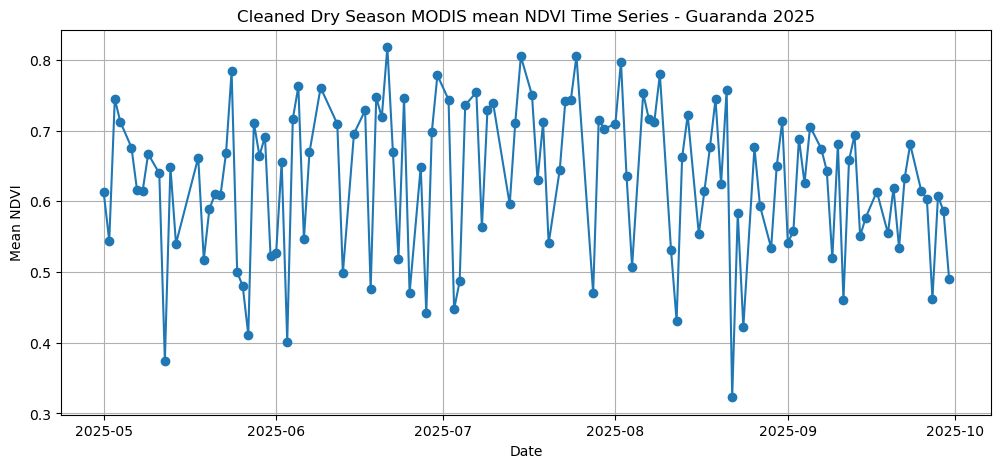

In [6]:
## MODIS NDVI COLLECTION

# Get the modis images for the dry season in the aoi
modis = ee.ImageCollection('MODIS/061/MOD09GA').filterBounds(aoi).filterDate('2025-05-01', '2025-10-01')

# QA Mask function
def mask_modis(image):

    state = image.select('state_1km')
    cloud_state = state.bitwiseAnd(0b11 << 0).rightShift(0)
    cloud_shadow = state.bitwiseAnd(0b1 << 2).rightShift(2)
    land_water = state.bitwiseAnd(0b111 << 3).rightShift(3)

    qc = image.select('QC_500m')
    modland = qc.bitwiseAnd(0b11 << 0).rightShift(0)

    mask = cloud_state.eq(0).And(cloud_shadow.eq(0)).And(land_water.eq(1)).And(modland.eq(0))

    return image.updateMask(mask)

# Create and add the NDVI band + valid pixels (pixels with ndvi!=0)
def add_ndvi(image):

    ndvi = image.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename('NDVI')

    valid_pixels = ndvi.mask().reduceRegion(reducer = ee.Reducer.count(),
                                            geometry = aoi,
                                            scale = 500,
                                            maxPixels = 1e13).get('NDVI') # the reduceRegion() gives a ditionary as a result: {'ndvi': n.ofValidPixels}. The get('ndvi') takes the value of 'ndvi' from a dictionary and converts it in a number

    return image.addBands(ndvi).set('valid_pixels', valid_pixels) # the valid_pixels is stored as a metadata on the image

modis_clean_ndvi = modis.map(mask_modis).map(add_ndvi)

# Reduce to NDVI mean + valid pixels
def get_mean(image):
    
    mean_dict = image.select('NDVI').reduceRegion(reducer = ee.Reducer.mean(),
                                                  geometry = aoi,
                                                  scale = 500,
                                                  maxPixels = 1e13) # stats is a dictionary
    
    return ee.Feature(None, #no geometry
                      {'date': image.date().format('YYYY-MM-dd'),
                       'NDVI': mean_dict.get('NDVI'),
                       'valid_pixels': image.get('valid_pixels'),
                       'id': image.id()})

ndvi_fc = modis_clean_ndvi.map(get_mean)

# Convert to Pandas DataFrame
ndvi_list = ndvi_fc.getInfo()['features'] # pulls the data to the Python dictionary, accessing the list of features in the FeatureCollection

data = [(f['properties'].get('date'), # for each feature it extract the value of 'date', 'NDVI', ...
         f['properties'].get('NDVI'),
         f['properties'].get('valid_pixels'),
         f.get('id')) 
        for f in ndvi_list
        if f['properties'].get('NDVI') is not None]

ndvi_df = pd.DataFrame(data, columns=['date', 'NDVI', 'valid_pixels', 'id'])
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df['NDVI'] = pd.to_numeric(ndvi_df['NDVI'])
ndvi_df['valid_pixels'] = pd.to_numeric(ndvi_df['valid_pixels'])
ndvi_df = ndvi_df.dropna().sort_values('date') # remove missing ndvi values and sort by date

# Filter by valid pixels (eliminate those images where the number of valid pixels is less than 30% of the maximum valid pixel number between the images). This makes the time series more reliable
max_valid = ndvi_df['valid_pixels'].max()
threshold = 0.3 * max_valid
ndvi_df = ndvi_df[ndvi_df['valid_pixels'] >= threshold]

# Outlier removal
Q1 = ndvi_df['NDVI'].quantile(0.25)
Q3 = ndvi_df['NDVI'].quantile(0.75)
IQR = Q3 - Q1
lower_outlier_limit = Q1 - 1.5*IQR
upper_outlier_limit = Q3 + 1.5*IQR

ndvi_clean = ndvi_df[(ndvi_df['NDVI'] >= lower_outlier_limit) & (ndvi_df['NDVI'] <= upper_outlier_limit)]

# Plot clean NDVI time series
plt.figure(figsize=(12, 5))
plt.plot(ndvi_clean['date'], ndvi_clean['NDVI'], marker='o', linestyle='-')
plt.title('Cleaned Dry Season MODIS mean NDVI Time Series - Guaranda 2025')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.grid(True)
plt.show()

In [6]:
# Export each clean NDVI image to local GEOTiffs
output_dir = r"C:\Users\Francesco\Python\earthlab\data\Ecuador\outputs"
os.makedirs(output_dir, exist_ok=True)

modis_list = modis_clean_ndvi.toList(modis_clean_ndvi.size()) # create the list of images in python from the ImageCollactiion in GEE (I need to specify how many images to include)
n = modis_clean_ndvi.size().getInfo() # get the value of the number of images in the collection

for i in range(n): # _ means that I don't consider the index in the iteration
    
    img = ee.Image(modis_list.get(i)) # get the image

    date_ms = img.get('system:time_start').getInfo() # get the date value of the image
    date_str = pd.to_datetime(date_ms, unit='ms').strftime('%Y%m%d') # make the date in a data format like 20250501

    out_name = f'NDVI_{date_str}.tif'
    out_path = os.path.join(output_dir, out_name)

    try: 
        geemap.ee_export_image(img,
                               filename=out_path,
                               scale=500,
                               region=aoi,
                               file_per_band=False)
        print(f'Saved: {out_name}')
        time.sleep(10) # pause to avoid throttling
    except Exception as e:
        print(f'Failed: {out_name}, {e}')

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Francesco\Python\earthlab\data\Ecuador\outputs\NDVI_20250501.tif
Saved: NDVI_20250501.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Francesco\Python\earthlab\data\Ecuador\outputs\NDVI_20250502.tif
Saved: NDVI_20250502.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Francesco\Python\earthlab\data\Ecuador\outputs\NDVI_20250503.tif
Saved: NDVI_20250503.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Francesco\Python\earthlab\data\Ecuador\outputs\NDVI_20250504.tif
Saved: NDVI_20250504.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Francesco\Python\earthlab\data\Ecuador\outputs\NDVI_20250505.tif
Saved: NDVI_20250505.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Francesco\Python\earthlab\data\Ecuador\outputs\NDVI_20250506.tif
Saved: NDVI_20250506.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Francesco\Python\ea

In [9]:
# Merge NDVI GEOTiffs into a multi-band stack file

tif_folder = r"C:\Users\Francesco\Python\earthlab\data\Ecuador\outputs"
tif_list = sorted(glob.glob(os.path.join(tif_folder, 'NDVI_*.tif')))

if len(tif_list) == 0:
    raise FileNotFoundError('No NDVI_*.tif files found in the specific folder')

# Create output file
merged_tif = os.path.join(tif_folder, 'NDVI_stack.tif')

# Open all files
datasets = [gdal.Open(tif_path, gdal.GA_ReadOnly) for tif_path in tif_list]
bands = [ds.GetRasterBand(1).ReadAsArray() for ds in datasets]

# Stack all the NDVI bands
ndvi_stack = np.stack(bands, axis=0)

# Get the georeference info from the first image
ref_ds = datasets[0]
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(merged_tif,
                       ref_ds.RasterXSize,
                       ref_ds.RasterYSize,
                       len(tif_list),
                       gdalconst.GDT_Float32)
out_ds.SetGeoTransform(ref_ds.GetGeoTransform())
out_ds.SetProjection(ref_ds.GetProjection())

# Write each NDVI image as a new band
for i, ndvi_band in enumerate(ndvi_stack):
    out_band = out_ds.GetRasterBand(i+1)
    out_band.WriteArray(ndvi_band)
    date = os.path.basename(tif_list[i].replace('NDVI', '').replace('.tif', ''))
    out_band.SetDescription(date)
    out_band.SetNoDataValue(-9999)

out_ds.FlushCache()
out_ds = None
print(f'Multi-band stack NDVI created at: {merged_tif}')

Multi-band stack NDVI created at: C:\Users\Francesco\Python\earthlab\data\Ecuador\outputs\NDVI_stack.tif


In [10]:
# Export to NetCDF

# Extracts dates from filenames
dates = [os.path.basename(f).split('_')[1].split('.')[0] for f in tif_list]
dates = pd.to_datetime(dates, format='%Y%m%d')

# Convert NDVI stack to xarray dataset
da = xr.DataArray(ndvi_stack,
                  dims = ['time', 'y', 'x'],
                  coords = {'time': dates},
                  name = 'NDVI')
ds = xr.Dataset({'NDVI': da})

netcdf_path = os.path.join(tif_folder, 'NDVI_stack.nc')
ds.to_netcdf(netcdf_path)
print(f'The NetCDF NDVI stack is saved at: {netcdf_path}')

The NetCDF NDVI stack is saved at: C:\Users\Francesco\Python\earthlab\data\Ecuador\outputs\NDVI_stack.nc


-1.0 7.0 float32


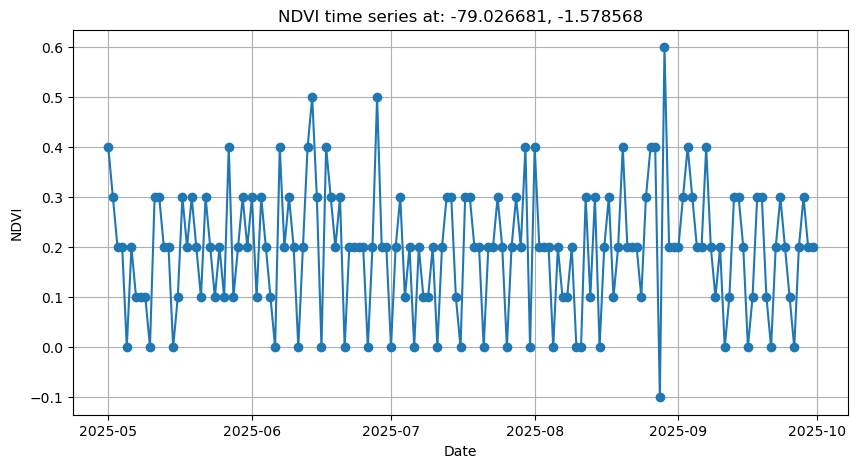

In [27]:
# Plot the NDVI time series for a pixel

ndvi = rxr.open_rasterio(r"C:\Users\Francesco\Python\earthlab\data\Ecuador\outputs\NDVI_stack.tif")
print(ndvi.values.min(), ndvi.values.max(), ndvi.dtype)
ndvi = ndvi.astype(float)*0.1 # rescale correctly because during the export in GEE of MODIS images I didn't applied the scaling factor *0.0001

# Coordinates to analyse
lon, lat = -79.026681, -1.578568

# Assign the time coordinate to the 'band' dimension (the xarray.DataArray ndvi has three dimensions (band: n° of images, y, x))
ndvi = ndvi.assign_coords(time=('band', dates)).swap_dims({'band':'time'})

ndvi_wgs84 = ndvi.rio.reproject('EPSG:4326')
pixel_ts = ndvi.sel(x=lon, y=lat, method='nearest')

plt.figure(figsize=(10, 5))
plt.plot(pixel_ts['time'], pixel_ts.values, marker='o')
plt.title(f'NDVI time series at: {lon}, {lat}')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.grid(True)
plt.show()

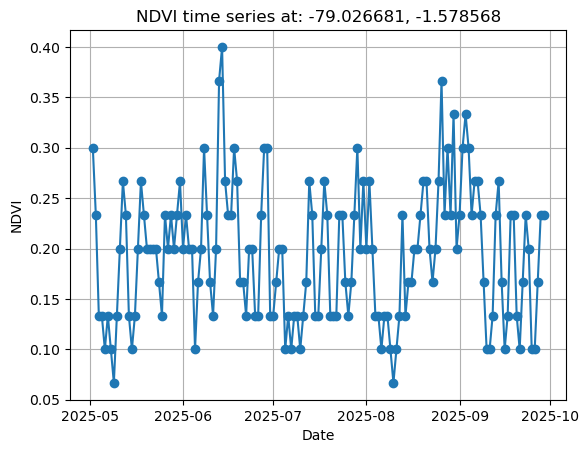

In [13]:
# Smoothe (reduce noise from cloud contamination or residual masking issues) with a moving average to reveal underlying vegetation trend better
smoothed_ndvi = pd.Series(pixel_ts.values, index=pixel_ts['time'].values).rolling(window=3, center=True).mean()
plt.plot(pixel_ts['time'], smoothed_ndvi, marker='o')
plt.title(f'NDVI time series at: {lon}, {lat}')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.grid(True)
plt.show()

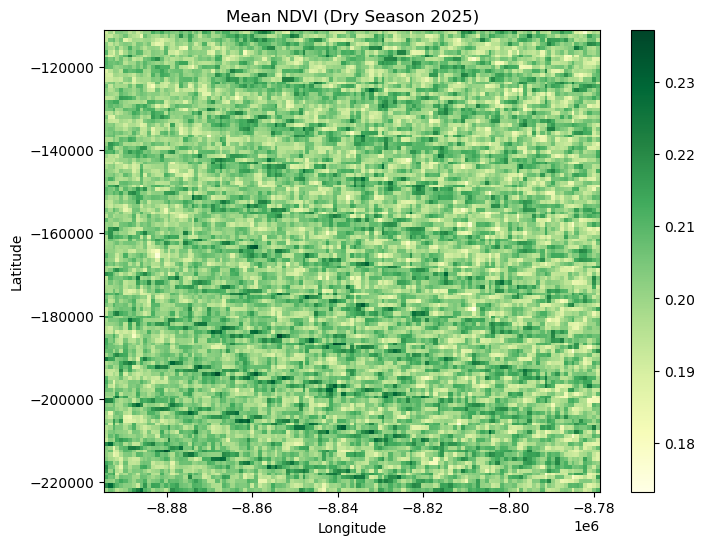

In [ ]:
#Compute mean NDVI map per pixel
mean_ndvi = ndvi.mean(dim="time")

plt.figure(figsize=(8, 6))
mean_ndvi.plot(cmap="YlGn")
plt.title("Mean NDVI (Dry Season 2025)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

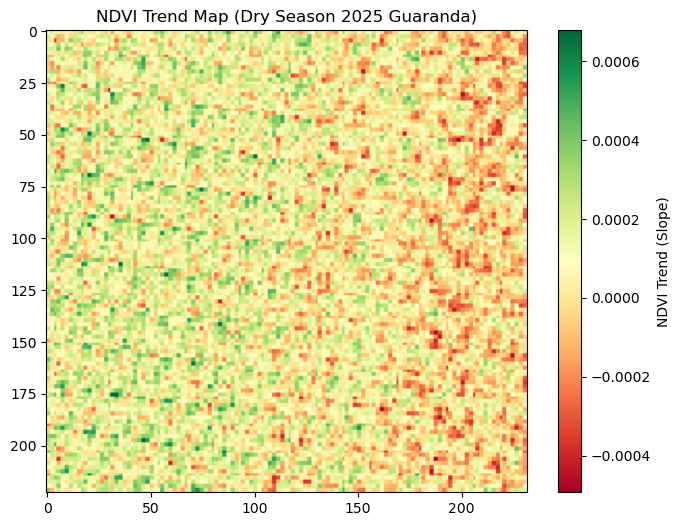

In [24]:
# PIXEL-WISE NDVI TREND SLOPE ANALYSIS

# Get the days in the time period (e.g. 0, 1, 2, ..., n_time-1)
time_numeric = np.arange(ndvi.shape[0])

# Reshape for easier math
T, Y, X = ndvi.shape
ndvi_reshaped = ndvi.values.reshape(T, -1) # I get a new array (T, Y*X) where I have 'time' in the rows and 'pixel' in the colums

# Create an array full of NaN with the dimension of the number of pixels
slopes = np.full(ndvi_reshaped.shape[1], np.nan)

# Compute the linerar regression between NDVI and time for each pixel, and get the slope
for idx in range(ndvi_reshaped.shape[1]):
    y = ndvi_reshaped[:, idx]
    if np.sum(np.isfinite(y)) > 1:
        slope, _, _, _, _ = linregress(time_numeric, y)
        slopes[idx] = slope

# Reshape back to image
slope_map = slopes.reshape(Y, X)

# Plot the Slope Map
plt.figure(figsize=(8, 6))
plt.imshow(slope_map,
           cmap='RdYlGn')
plt.colorbar(label='NDVI Trend (Slope)')
plt.title('NDVI Trend Map (Dry Season 2025 Guaranda)')
plt.show()